In [1]:
import os 
#Reading the dataset
tahrah_dir = '/kaggle/input/llm-detect-ai-generated-text/'

for dirname, _, filenames in os.walk(tahrah_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


In [2]:
#Installing the KerasNLP package 
!pip install keras-core --upgrade
!pip install -q keras-nlp
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 11.5 MB/s eta 0:00:0000:010:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [3]:
#Import the environemnt, libraries as necessary 
import os 
os.environ['KERAS_BACKEND'] = 'tensorflow' # or "jax" or "torch"
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt

# Use mixed precision to speed up all training in this guide.
keras.mixed_precision.set_global_policy("mixed_float16")


print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("KerasNLP version:", keras_nlp.__version__)

2024-06-03 00:42:57.628461: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 00:42:57.628631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 00:42:57.769453: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend
TensorFlow version: 2.15.0
Keras version: 0.1.7
KerasNLP version: 0.12.1


In [4]:
#Exploring the dataset, check the column, nulls 
df_train_prompts = pd.read_csv(tahrah_dir + "train_prompts.csv")
print(df_train_prompts.info())
df_train_prompts.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   prompt_id     2 non-null      int64 
 1   prompt_name   2 non-null      object
 2   instructions  2 non-null      object
 3   source_text   2 non-null      object
dtypes: int64(1), object(3)
memory usage: 192.0+ bytes
None


,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [5]:
df_train_essays = pd.read_csv(tahrah_dir + "train_essays.csv")
print(df_train_essays.info())
df_train_essays.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB
None


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
5,00da8c32,1,The electrol college system is an unfair syste...,0
6,011dc2bc,1,"Dear state senator, It is the utmost respect t...",0
7,01448434,0,"Fellow citizens, cars have become a major role...",0
8,01c6e176,1,"""It's official: The electoral college is unfai...",0
9,0202ddf9,1,The Electoral College has been kept for centur...,0


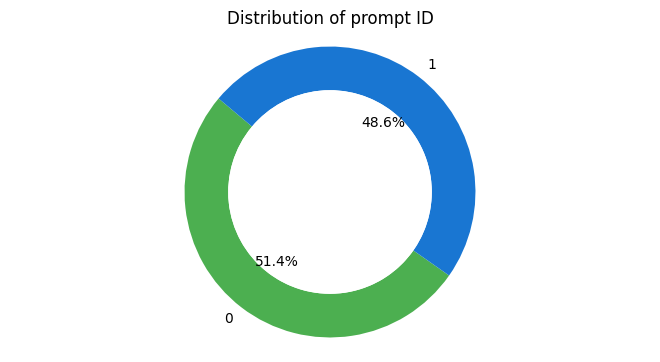

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the values for the 'prompt_id' column
counts = df_train_essays['prompt_id'].value_counts()
labels = counts.index
sizes = counts.values

# Define custom colors (light blue and dark blue)
custom_colors = ['#4CAF50', '#1976D2']  # Light blue and dark blue colors

# Create the donut chart
plt.figure(figsize=(8, 4))
wedges, texts, autotexts = plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=custom_colors, wedgeprops=dict(width=0.3))
plt.title("Distribution of prompt ID")

# Add a circle at the center to turn the pie into a donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Adjust layout
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

plt.show()


## 51.4% are human generated and 48.6% is by AL. 

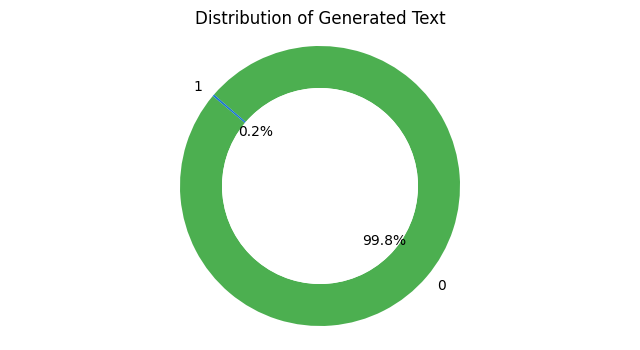

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the values for the 'generated' column
counts = df_train_essays['generated'].value_counts()
labels = counts.index
sizes = counts.values

# Define custom colors (light blue and dark blue)
custom_colors = ['#4CAF50', '#1976D2']  # Light blue and dark blue colors

# Create the donut chart
f, ax = plt.subplots(figsize=(8, 4))
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=custom_colors, wedgeprops=dict(width=0.3))
ax.set_title("Distribution of Generated Text")

# Add a circle at the center to turn the pie into a donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

plt.show()




## 99.8%% are human generated and 0.2% is by AL. 

In [8]:
# Checking. if you run anay issues not loading your visuals please check if your directory names needed to get changed or you can check if the column exists in the particular datset or not. 
print(df_train_essays.columns)


Index(['id', 'prompt_id', 'text', 'generated'], dtype='object')


In [9]:
print(df_train_essays.columns.tolist())


['id', 'prompt_id', 'text', 'generated']


In [10]:
print(df_train_essays.head())

         id  prompt_id                                               text  \
0  0059830c          0  Cars. Cars have been around since they became ...   
1  005db917          0  Transportation is a large necessity in most co...   
2  008f63e3          0  "America's love affair with it's vehicles seem...   
3  00940276          0  How often do you ride in a car? Do you drive a...   
4  00c39458          0  Cars are a wonderful thing. They are perhaps o...   

   generated  
0          0  
1          0  
2          0  
3          0  
4          0  


In [11]:
# Print all column names to check if there's a similar one
columns = df_train_essays.columns.tolist()
print(columns)

# Find columns that might be similar to 'generated'
similar_columns = [col for col in columns if 'generated' in col.lower()]
print(similar_columns)


['id', 'prompt_id', 'text', 'generated']
['generated']


In [12]:
#Feeding more new data
df_train_essays_ext = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv')

df_train_essays_ext.rename(columns = {"label":"generated"}, inplace=True)

df_train_essays_ext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44206 entries, 0 to 44205
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   44206 non-null  object
 1   text       44206 non-null  object
 2   generated  44206 non-null  int64 
 3   source     44206 non-null  object
 4   prompt     12911 non-null  object
 5   fold       44206 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [13]:
df_train_essays_ext.head()

,essay_id,text,generated,source,prompt,fold
0,E897534557AF,"In recent years, technology has had a profoun...",1,mistral7binstruct_v2,\nTask: Write an essay discussing the positive...,1
1,DFBA34FFE11D,Should students participate in an extracurricu...,0,persuade_corpus,NaN,2
2,af37ecf5,The electoral college is a symbol of mockery a...,0,train_essays,NaN,5
3,5EC2696BAD78,This is why I think the principle should allow...,0,persuade_corpus,NaN,8
4,llama_70b_v1843,I strongly believe that meditation and mindful...,1,llama_70b_v1,Some schools have implemented meditation and m...,0


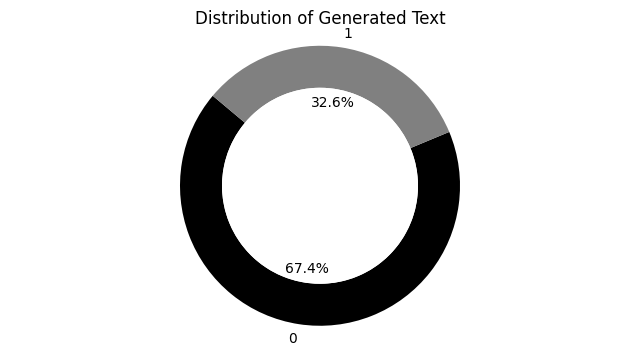

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_train_essays_ext is already defined and loaded with data
counts = df_train_essays_ext['generated'].value_counts()
labels = counts.index
sizes = counts.values

# Define a custom color palette with black and gray
custom_colors = ['black', 'gray'] + sns.color_palette("husl", len(labels) - 2)

# Create the donut chart
f, ax = plt.subplots(figsize=(8, 4))
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=custom_colors, wedgeprops=dict(width=0.3))

# Add a circle at the center to turn the pie into a donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.set_title("Distribution of Generated Text")
plt.axis('equal')
plt.show()


In [15]:
#Look at the new dataset now 
df_train_essays

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


In [16]:
df_train_essays_final = pd.concat([df_train_essays_ext[["text", "generated"]], df_train_essays[["text", "generated"]]])

df_train_essays_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45584 entries, 0 to 1377
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       45584 non-null  object
 1   generated  45584 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [17]:
# After the concatenation of the datasets 
df_train_essays_final

,text,generated
0,"In recent years, technology has had a profoun...",1
1,Should students participate in an extracurricu...,0
2,The electoral college is a symbol of mockery a...,0
3,This is why I think the principle should allow...,0
4,I strongly believe that meditation and mindful...,1
...,...,...
1373,There has been a fuss about the Elector Colleg...,0
1374,Limiting car usage has many advantages. Such a...,0
1375,There's a new trend that has been developing f...,0
1376,As we all know cars are a big part of our soci...,0


# Preprocessiong the data 


In [18]:
df_train_essays["text_length"] = df_train_essays["text"].apply(lambda x : len(x.split()))

In [19]:
df_train_essays["text_length"].mean() + df_train_essays["text_length"].std()

716.0440978092684

/tmp/ipykernel_33/3461133077.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')
/tmp/ipykernel_33/3461133077.py:15: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_train_essays, x="text_length", ax=ax, palette=custom_palette)
/tmp/ipykernel_33/3461133077.py:15: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.swarmplot(data=df_train_essays, x="text_length", ax=ax, palette=custom_palette)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf

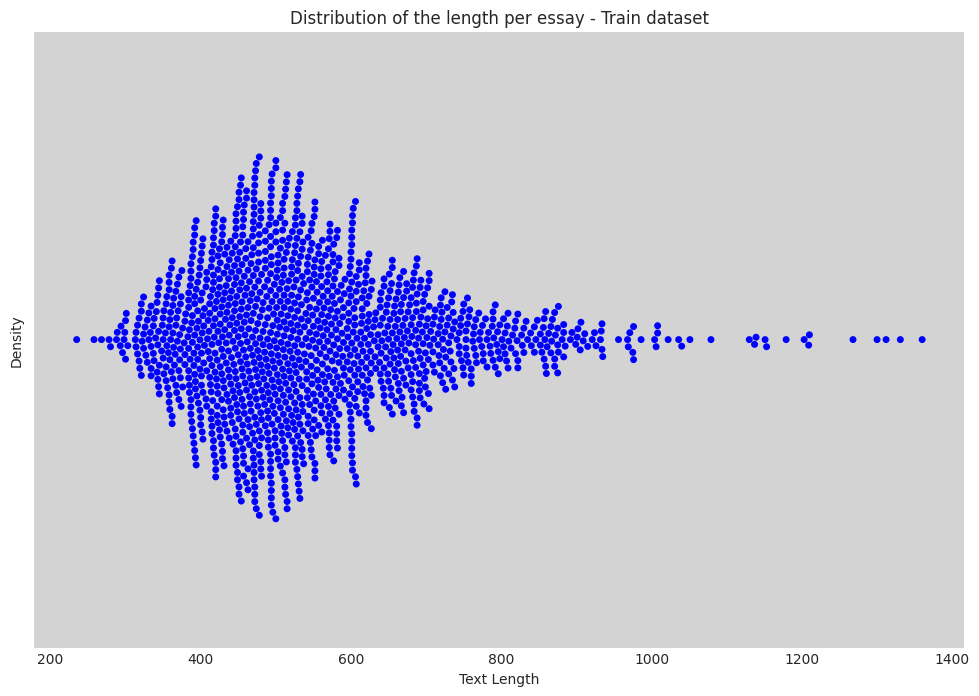

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the desired color palette
custom_palette = ["blue", "green"]

# Set the plot style and background color
plt.style.use('seaborn-dark')
plt.rcParams['axes.facecolor'] = 'lightgray'

# Create a figure with subplots
fig, ax = plt.subplots(figsize=(12, 8))

# Create a swarm plot with custom color palette
sns.swarmplot(data=df_train_essays, x="text_length", ax=ax, palette=custom_palette)

# Set the title and labels
ax.set_title("Distribution of the length per essay - Train dataset")
ax.set_xlabel("Text Length")
ax.set_ylabel("Density")

# Show the plot
plt.show()


# LLM model 
# Preprocessing distil_bert_tokenizer

In [21]:
from tensorflow import keras
import keras_nlp

# Set the desired sequence length
SEQ_LENGTH = 512

# Use DistilBERT preprocessor with the specified sequence length
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    "distil_bert_base_en_uncased",
    sequence_length=SEQ_LENGTH,
)

# Initialize a DistilBERT classifier with the preprocessor and number of output classes
classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    "distil_bert_base_en_uncased",
    num_classes=2,  # Assuming binary classification, adjust as needed
    activation=None,  # No activation function specified for logits
    preprocessor=preprocessor,
)

# Compile the classifier with appropriate loss, optimizer, and metrics
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Sparse categorical cross-entropy loss
    optimizer=keras.optimizers.Adam(5e-4),  # Adam optimizer with learning rate 5e-4
    metrics=[keras.metrics.SparseCategoricalAccuracy()],  # Sparse categorical accuracy metric
)

# Set the DistilBERT backbone to non-trainable
classifier.backbone.trainable = False

# Print the summary of the classifier model
classifier.summary()


Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'preprocessor.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'task.

Preprocessor: "distil_bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ distil_bert_backbone (DistilBertBackbone)     │ (None, None, 768)                      │      66,362,880 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ tf.__operators__.getitem (SlicingOpLambda)    │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ pooled_dense (Dense)                          │ (None, 768)                            │         590,592 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ output_dropout (Dropout)                      │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,538 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 592,130 (2.26 MB)

 Non-trainable params: 66,362,880 (253.15 MB)

In [22]:
# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train_essays_final["text"],
                                                    df_train_essays_final["generated"],
                                                    test_size=0.33,
                                                    random_state=42)

In [ ]:
# Fit
classifier.fit(x=X_train, 
               y=y_train,
               validation_data=(X_test, y_test),
               epochs=1,
               batch_size=64
              )

I0000 00:00:1717375456.467060     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-06-03 00:44:16.485376: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


136/478 [=======>......................] - ETA: 9:36:33 - loss: 0.4793 - sparse_categorical_accuracy: 0.7804

In [ ]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Generated","Generated"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))


In [ ]:
y_pred_test = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def display_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set_title(title)
    plt.show()

# Assuming y_test and y_pred_test are your true and predicted labels for the test set
display_confusion_matrix(y_test, y_pred_test, "Test Confusion Matrix")
